# Run CycleGAN

In [1]:
import torch
from src.data.dataloaders import  CycleGANDataModule
from src.models.CycleGan import CycleGan
import tifffile

In [2]:
def toImage(x):
    x = x.squeeze()
    x = x.numpy()
    x = x.astype('uint8')
    return x

In [3]:
# del model

In [4]:
model = CycleGan()

In [5]:
model_path = "../models/CycleGAN_TPWN-2023-11-29-2038/CycleGAN-epoch=69.ckpt"
model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
torch._dynamo.config.suppress_errors = True
model = torch.compile(model)
model = model.cuda()
model.eval();

In [6]:
datamodule = CycleGANDataModule(batch_size=1, num_workers=0)

In [7]:
datamodule.setup(stage="test")

Found 1000 images of validationA and 100 images of validationB


In [8]:
dataloader = datamodule.test_dataloader()

In [9]:
iterable = iter(dataloader)

In [10]:
batch = next(iterable)

In [11]:
imgA = batch["A"]
imgA = imgA.to("cuda")
imgB = batch["B"]
imgB = imgB.to("cuda")

In [12]:
fakeB = torch.nn.functional.sigmoid(model.genX(imgA))*255 
cycledA = torch.nn.functional.sigmoid(model.genY(fakeB))*255 

fakeA = torch.nn.functional.sigmoid(model.genY(imgB))*255 
cycledB = torch.nn.functional.sigmoid(model.genX(fakeA))*255 

sameB = torch.nn.functional.sigmoid(model.genX(imgB))*255 
sameA = torch.nn.functional.sigmoid(model.genY(imgA))*255 

In [13]:
fakeA = toImage(fakeA.cpu().detach())
fakeB = toImage(fakeB.cpu().detach())
sameA = toImage(sameA.cpu().detach())
sameB = toImage(sameB.cpu().detach())
cycledA = toImage(cycledA.cpu().detach())
cycledB = toImage(cycledB.cpu().detach())
imgA = imgA.squeeze().to(torch.uint8).cpu().numpy()
imgB = imgB.squeeze().to(torch.uint8).cpu().numpy()

In [14]:
tifffile.imwrite("fakeA.tif",fakeA)
tifffile.imwrite("fakeB.tif",fakeB)
tifffile.imwrite("sameA.tif",sameA)
tifffile.imwrite("sameB.tif",sameB)
tifffile.imwrite("cycledA.tif",cycledA)
tifffile.imwrite("cycledB.tif",cycledB)
tifffile.imwrite("imgA.tif",imgA)
tifffile.imwrite("imgB.tif",imgB)

# Metric

98.5% accuracy of metric on synthetic mixes

# Test model on metric

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.data.dataloaders import MetricDataset#, BugNISTDataModule
from src.models.unet import UNet_pl
from src.models.swin_unetr import SwinUNETR_pl as SwinUNETR
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np

In [2]:
torch.set_float32_matmul_precision("medium")

# model = UNet_pl(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=13,
#     channels=(4, 8, 16, 32, 64),
#     strides=(2, 2, 2, 2),
#     lr=1,
# )
# model = UNet_pl(
#         spatial_dims=3,
#         in_channels=1,
#         out_channels=13,
#         channels=(16, 32, 64, 128, 256, 512),
#         strides=(2, 2, 2, 2, 2),
#         num_res_units = 3,
#     )
model = SwinUNETR(img_size=(256,128,128), in_channels=1, out_channels=13, feature_size=24)

# model_path = "../models/small50000v3-2024-01-29-1606/UNet_small-epoch=79.ckpt"
# model_path = "../models/large50000v3-2024-02-02-0054/UNet_large-epoch=36.ckpt"
model_path = "../models/swin20000v3-2024-02-04-0838/SwinUNETR-epoch=5.ckpt"
model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
    
torch._dynamo.config.suppress_errors = True
# model = torch.compile(model)
model.eval();
model = model.to("cuda")

In [3]:
test_loader = DataLoader(MetricDataset(),
                         batch_size=1,
                         num_workers=0)

In [4]:
color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}
accuracies = []
for k,(img,label) in enumerate(tqdm(test_loader, unit="batch")):
    img = img.to("cuda")
    with torch.no_grad():
        preds = model(img);
        preds_sm = preds.softmax(dim=1).cpu().numpy();

        class_props = []
        for i in range(1, 13):  # For each class channel
            props = measure.regionprops(
        
                #                        v-- softmax channel for this class
        
                measure.label(preds_sm[0, i] > 0.25)  # Threshold softmax probability at 0.25
        
            )
        
            props = [p for p in props if p.area > 5**3]  # Remove small connected components
        
            class_props.append(props)
        
        for i, props in enumerate(class_props):
            # For every found connected component
            for p in props:
                bb = p.bbox
        
                # Sets the found connected component to the mean value of the connected component
                preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image] = preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image].mean()
        
        out = torch.Tensor(preds_sm).softmax(dim=1).argmax(dim=1).to(torch.uint8)
        accuracies.append(sum(out[out != 0] == label[out != 0])/len(label[out != 0]))
        
        comparison = torch.zeros(label.shape)
        
        comparison[out == label] = 2 # Finds correctly labelled pixels
        comparison[out != label] = 1 # Finds wrongly labelled pixels
        comparison[out == 0] = 0    # Removes background pixels
        
        
        rgba_img = torch.zeros(256,128,128,4)
        
        rgba_img[:,:,:,1][comparison[0] == 2] = 128 # Set colour of correctly labelled pixels to green
        rgba_img[:,:,:,3][comparison[0] == 2] = 128 # Set transparency of correctly labelled pixels
        rgba_img[:,:,:,0][comparison[0] == 1] = 128 # Set colour of wrongly labelled pixels to red
        rgba_img[:,:,:,3][comparison[0] == 1] = 128 # Set transparency of wrongly labelled pixels
        rgba_img[:,:,:,3][comparison[0] == 0] = 255 # Set transparency of background (fully transparent)
        tifffile.imwrite(f"results_swin/{test_loader.dataset.get_name_of_image(k)}_acc={accuracies[k]:.3f}.tif",rgba_img.to(torch.uint8).numpy())

        rgba_img = torch.zeros(256,128,128,4)
        for i in range(0,13):
            if i == 0:
                rgba_img[:,:,:,3][(out == i).squeeze()] = 255
            else:
                rgba_img[:,:,:,0][(out == i).squeeze()] = color_dict[i][0]
                rgba_img[:,:,:,1][(out == i).squeeze()] = color_dict[i][1]
                rgba_img[:,:,:,2][(out == i).squeeze()] = color_dict[i][2]
                rgba_img[:,:,:,3][(out == i).squeeze()] = 128
        tifffile.imwrite(f"results_swin/{test_loader.dataset.get_name_of_image(k)}_acc={accuracies[k]:.3f}_coloured.tif",rgba_img.to(torch.uint8).numpy())

100%|██████████| 388/388 [27:15<00:00,  4.22s/batch]


In [5]:
accuracies = torch.Tensor(accuracies)

In [7]:
accuracies.mean()

tensor(0.1733)

In [15]:
accuracies.argmax()

tensor(335)

In [20]:
accuracies[15]

tensor(0.9979)

In [27]:
test_loader.dataset.image_paths[257]

'/work3/s164564/Thesis/Synthetic_Context/data/cyclegan_256/trainB/02/Mix 6_007.tif'

19.7% accuracy with model train on synthetic mixes

20.2% accuracy with model train on GAN images

26.7% accuracy with model train on new and improved synthetic mixes

29.0% accuracy with model train on new and improved synthetic mixes with background noise

30.5% accuracy with connected component analysis on softmax predictions (and improved synthetic mixes)

51.4% accuracy with large model (and all previous improvements) (5000 data points)

59.3%/56.1%/63.2%/62.1% accuracy with large model (and all previous improvements) (20000 data points)

57.1%/58.6%/57.7%/56.9% accuracy with large model and umap subset (14368 data points)

59.3%/59.3%/57.5% accuracy with large model and pca subset (16742 data points)

63.8% accuracy with large model (and all previous improvements) (~50000 data points)

61.4% accuracy with large model and feature distance subset (20000 data points) without skip-connections

62.2% accuracy SwinUNETR (~50000 data points)

# Testing old models on new data

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.data.dataloaders import BugNISTDataModule
from src.models.unet import UNet_pl
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np
from torchmetrics import Dice

In [2]:
torch.set_float32_matmul_precision("medium")

# model = UNet_pl(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=13,
#     channels=(4, 8, 16, 32, 64),
#     strides=(2, 2, 2, 2),
#     lr=1,
# )
model = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )

model_path = "../models/UNet_large-2023-12-06-1549/UNet-epoch=79.ckpt"
# model_path = "../models/UNet_no_noise-2023-11-13-1713/UNet-epoch=343.ckpt"
# model_path = "../models/UNet_old-2023-09-20-2208/UNet-epoch=229.ckpt"
# model_path = "../models/UNet-2023-11-03-0950/UNet-epoch=498.ckpt"
model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
    
torch._dynamo.config.suppress_errors = True
model = torch.compile(model)
model.eval();
model = model.to("cuda")

In [3]:
bugnist = BugNISTDataModule(batch_size=10, num_workers=0, mix=True,no_noise=False,old=False)
bugnist.setup()

test_loader = bugnist.test_dataloader()

In [4]:
color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}
accuracies = []
dice_scores = []
dice_score = Dice(num_classes=13, ignore_index=0)
for k,(img,label) in enumerate(tqdm(test_loader, unit="batch")):
    img = img.to("cuda")
    with torch.no_grad():
        preds = model(img);
        preds_sm = preds.softmax(dim=1).cpu().numpy();

        class_props = []
        for i in range(1, 13):  # For each class channel
            props = measure.regionprops(
        
                #                        v-- softmax channel for this class
        
                measure.label(preds_sm[0, i] > 0.25)  # Threshold softmax probability at 0.5
        
            )
        
            props = [p for p in props if p.area > 5**3]  # Remove small connected components
        
            class_props.append(props)
        
        for i, props in enumerate(class_props):
            # For every found connected component
            for p in props:
                bb = p.bbox
        
                # Sets the found connected component to the mean value of the connected component
                preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image] = preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image].mean()
        
        out = torch.Tensor(preds_sm).softmax(dim=1).argmax(dim=1).to(torch.uint8)
        dice_scores.append(dice_score(out,label))
        accuracies.append(sum(out[out != 0] == label[out != 0])/len(label[out != 0]))

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [46:54<00:00, 56.29s/batch]


In [5]:
print("dice score",torch.Tensor(dice_scores).mean())
print("accuracy",torch.Tensor(accuracies).mean())

dice score tensor(0.9117)
accuracy tensor(0.9047)


|                       Model                       | Dice score | Accuracy |
|:-------------------------------------------------:|:----------:|:--------:|
|                   Loose Packing                   |       0.41 |     0.40 |
|                 Tight Packing (nn)                |       0.45 |     0.43 |
|                 Tight Packing (wn)                |       0.65 |     0.64 |
| Majority voting of 3 models<br>Tight Packing (wn) |       0.69 |     0.69 |.69 
|                  Large model TPWN                 |       0.91 |     0.90 |   ||0 |

                                                                        nn = no noise     wn = with noise

# Testing majority voting of multiple models

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.data.dataloaders import BugNISTDataModule, MetricDataset
from src.models.unet import UNet_pl
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np
from torchmetrics import Dice

In [2]:
# bugnist = BugNISTDataModule(batch_size=32, num_workers=0, mix=True,no_noise=False,old=False)
# bugnist.setup()

# test_loader = bugnist.test_dataloader()


test_loader = DataLoader(MetricDataset(),
                         batch_size=1,
                         num_workers=0)

In [3]:
torch.set_float32_matmul_precision("medium")

model_1 = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )
model_2 = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )
model_3 = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )
model_4 = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )
model_5 = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )


model_1_path = f"{_PATH_MODELS}/UNet_large-2023-12-15-1448/UNet-epoch=38.ckpt"
model_2_path = f"{_PATH_MODELS}/UNet_large2-2024-01-03-1225/UNet-epoch=44.ckpt"
model_3_path = f"{_PATH_MODELS}/UNet_large3-2024-01-04-1338/UNet-epoch=58.ckpt"
model_4_path = f"{_PATH_MODELS}/UNet_large4-2024-01-04-1905/UNet-epoch=66.ckpt"
model_5_path = f"{_PATH_MODELS}/UNet_large5-2024-01-05-2309/UNet-epoch=40.ckpt"

model_1.load_state_dict(torch.load(model_1_path, map_location=None)['state_dict'], strict=True)
model_2.load_state_dict(torch.load(model_2_path, map_location=None)['state_dict'], strict=True)
model_3.load_state_dict(torch.load(model_3_path, map_location=None)['state_dict'], strict=True)
model_4.load_state_dict(torch.load(model_4_path, map_location=None)['state_dict'], strict=True)
model_5.load_state_dict(torch.load(model_5_path, map_location=None)['state_dict'], strict=True)
    
torch._dynamo.config.suppress_errors = True
model_1 = torch.compile(model_1)
model_2 = torch.compile(model_2)
model_3 = torch.compile(model_3)
model_4 = torch.compile(model_4)
model_5 = torch.compile(model_5)
model_1.eval();
model_2.eval();
model_3.eval();
model_4.eval();
model_5.eval();
model_1 = model_1.to("cuda")
model_2 = model_2.to("cuda")
model_3 = model_3.to("cuda")
model_4 = model_3.to("cuda")
model_5 = model_3.to("cuda")

models = [model_1,model_2,model_3,model_4,model_5]

In [4]:
color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}
accuracies = []
# dice_scores = []
# dice_score = Dice(num_classes=13, ignore_index=0)
for k,(img,label) in enumerate(tqdm(test_loader, unit="batch")):
    img = img.to("cuda")
    outs = []
    with torch.no_grad():
        for model in models:
            preds = model(img);
            preds_sm = preds.softmax(dim=1).cpu().numpy();
    
            class_props = []
            for i in range(1, 13):  # For each class channel
                props = measure.regionprops(
            
                    #                        v-- softmax channel for this class
            
                    measure.label(preds_sm[0, i] > 0.25)  # Threshold softmax probability at 0.5
            
                )
            
                props = [p for p in props if p.area > 5**3]  # Remove small connected components
            
                class_props.append(props)
            
            for i, props in enumerate(class_props):
                # For every found connected component
                for p in props:
                    bb = p.bbox
            
                    # Sets the found connected component to the mean value of the connected component
                    preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image] = preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image].mean()
            
            out = torch.Tensor(preds_sm).softmax(dim=1).argmax(dim=1).to(torch.uint8)
            outs.append(out)
        outs = [out.unsqueeze(dim=0) for out in outs]
        out = torch.concat(outs,dim=0).mode(0).values
        # dice_scores.append(dice_score(out,label))
        accuracies.append(sum(out[out != 0] == label[out != 0])/len(label[out != 0]))

        comparison = torch.zeros(label.shape)
        # temp = pred.softmax(dim=1).argmax(dim=1).to(torch.uint8).cpu()
        
        comparison[out == label] = 2 # Finds correctly labelled pixels
        comparison[out != label] = 1 # Finds wrongly labelled pixels
        comparison[out == 0] = 0    # Removes background pixels
        
        
        rgba_img = torch.zeros(256,128,128,4)
        
        rgba_img[:,:,:,1][comparison[0] == 2] = 128 # Set colour of correctly labelled pixels to green
        rgba_img[:,:,:,3][comparison[0] == 2] = 128 # Set transparency of correctly labelled pixels
        rgba_img[:,:,:,0][comparison[0] == 1] = 128 # Set colour of wrongly labelled pixels to red
        rgba_img[:,:,:,3][comparison[0] == 1] = 128 # Set transparency of wrongly labelled pixels
        rgba_img[:,:,:,3][comparison[0] == 0] = 255 # Set transparency of background (fully transparent)
        tifffile.imwrite(f"outputs_combined/{test_loader.dataset.get_name_of_image(k)}_acc={accuracies[k]:.3f}.tif",rgba_img.to(torch.uint8).numpy())

        rgba_img = torch.zeros(256,128,128,4)
        for i in range(0,13):
            if i == 0:
                rgba_img[:,:,:,3][(out == i).squeeze()] = 255
            else:
                rgba_img[:,:,:,0][(out == i).squeeze()] = color_dict[i][0]
                rgba_img[:,:,:,1][(out == i).squeeze()] = color_dict[i][1]
                rgba_img[:,:,:,2][(out == i).squeeze()] = color_dict[i][2]
                rgba_img[:,:,:,3][(out == i).squeeze()] = 128
        tifffile.imwrite(f"outputs_combined/{test_loader.dataset.get_name_of_image(k)}_acc={accuracies[k]:.3f}_coloured.tif",rgba_img.to(torch.uint8).numpy())

100%|████████████████████████████████████████████████████████████████████████████| 388/388 [1:09:28<00:00, 10.74s/batch]


In [6]:
# print("dice score",torch.Tensor(dice_scores).mean())
print("accuracy",torch.Tensor(accuracies).mean())

accuracy tensor(0.6319)


# Distance between features

In [26]:
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT

In [9]:
real = np.load("features/real_UNetNoSkipConnection_features.npy")
# test = np.load("features/tight_packing_wn_test_UNetNoSkipConnection_features.npy")
train = np.load("features/tight_packing_wn_train_UNetNoSkipConnection_features.npy")

In [10]:
real_distance = cdist(real,real)
real_distance = np.ma.array(real_distance, mask=False)
for i in range(real_distance.shape[0]):
    real_distance.mask[i,i] = True

In [11]:
real_distance.mean()

857.914875608836

In [12]:
real_distance.std()

51.05536610115451

In [13]:
train_distance = cdist(real,train)

In [14]:
train_distance_mean = train_distance.mean(axis=0)

In [15]:
df = pd.DataFrame(train_distance_mean,columns=["distance"])

In [16]:
df.sort_values(by="distance")

,distance
24944,808.647878
47697,809.346369
6212,809.863321
20322,811.495008
47149,811.531382
...,...
37831,1008.225646
8028,1008.260992
7706,1015.085494
626,1021.480253


In [17]:
df.sort_values(by="distance")[:20000]

,distance
24944,808.647878
47697,809.346369
6212,809.863321
20322,811.495008
47149,811.531382
...,...
44706,892.957909
4678,892.958018
9950,892.960552
28927,892.963581


In [18]:
data_train = pd.read_csv("../data/train.csv")

In [19]:
feature_distance_subset = pd.merge(data_train, df.sort_values(by="distance")[:20000], left_index=True, right_index=True)

In [20]:
feature_distance_subset.to_csv("train_feature_distance_subset.csv",index=False)

In [21]:
feature_distance_subset.distance.mean()

871.8911518503338

In [22]:
feature_distance_subset.distance.std()

14.785389666765184

In [41]:
dist_dict = {"BF":0,"CF":0,"PP":0,"MA":0,"BL":0,"ML":0,"SL":0,"WO":0,"BC":0,"GH":0,"AC":0,"GP":0}
total = 0
for centroid in feature_distance_subset.centroid_path:
    temp = pd.read_csv(f"{_PATH_DATA}/{centroid}",sep=";")
    for c in temp.Caption:
        dist_dict[c] += 1
    total += len(temp)

In [42]:
dist_dict

{'BF': 9091,
 'CF': 11800,
 'PP': 12202,
 'MA': 11987,
 'BL': 12541,
 'ML': 8511,
 'SL': 7493,
 'WO': 11808,
 'BC': 9744,
 'GH': 8226,
 'AC': 9090,
 'GP': 12296}

In [51]:
dist_dict = {"BF":0,"CF":0,"PP":0,"MA":0,"BL":0,"ML":0,"SL":0,"WO":0,"BC":0,"GH":0,"AC":0,"GP":0}
total = 0
for centroid in data_train.centroid_path:
    temp = pd.read_csv(f"{_PATH_DATA}/{centroid}",sep=";")
    for c in temp.Caption:
        dist_dict[c] += 1
    total += len(temp)

In [52]:
dist_dict

{'BF': 22777,
 'CF': 29338,
 'PP': 30486,
 'MA': 29959,
 'BL': 31169,
 'ML': 21175,
 'SL': 18903,
 'WO': 29517,
 'BC': 24524,
 'GH': 20401,
 'AC': 22654,
 'GP': 30663}

In [54]:
for item in dist_dict.items():
    print(item[0],item[1]/total)

BF 0.07310489591290449
CF 0.09416303447744619
PP 0.09784764704749556
MA 0.09615619162553038
BL 0.10003979895110507
ML 0.06796312819755686
SL 0.06067093328540341
WO 0.09473755159420476
BC 0.07871205458875487
GH 0.06547890334632149
AC 0.07271011599468491
GP 0.09841574497859201


# Check accuracies

In [1]:
import pandas as pd
from glob import glob
import re

In [7]:
files = glob(f"results_small/*_acc=*_coloured.tif")
acc_dict = {}
for file in files:
    temp = file.split("/")[1].split("_")
    name = "_".join([temp[0],temp[1]])
    acc = temp[2].split("=")[1]
    acc_dict[name] = acc
df_1 = pd.DataFrame.from_dict(acc_dict,orient="index",columns=["Accuracy_Small"])
df_1.Accuracy_Small = df_1.Accuracy_Small.astype("float")

In [8]:
files = glob(f"results_large/*_acc=*_coloured.tif")
acc_dict = {}
for file in files:
    temp = file.split("/")[1].split("_")
    name = "_".join([temp[0],temp[1]])
    acc = temp[2].split("=")[1]
    acc_dict[name] = acc
df_2 = pd.DataFrame.from_dict(acc_dict,orient="index",columns=["Accuracy_Large"])
df_2.Accuracy_Large = df_2.Accuracy_Large.astype("float")

In [9]:
files = glob(f"results_swin/*_acc=*_coloured.tif")
acc_dict = {}
for file in files:
    temp = file.split("/")[1].split("_")
    name = "_".join([temp[0],temp[1]])
    acc = temp[2].split("=")[1]
    acc_dict[name] = acc
df_3 = pd.DataFrame.from_dict(acc_dict,orient="index",columns=["Accuracy_Swin"])
df_3.Accuracy_Swin = df_3.Accuracy_Swin.astype("float")

In [10]:
df_acc = pd.merge(df_1,df_2, left_index=True, right_index=True)
df_acc = pd.merge(df_acc,df_3, left_index=True, right_index=True)

In [13]:
df_acc.sort_values(by="Accuracy_Small")

,Accuracy_Small,Accuracy_Large,Accuracy_Swin
Mix 20_011,0.067,0.400,0.338
Mix 11_009,0.075,0.571,0.392
Mix 3_010,0.122,0.663,0.519
Mix 8_002,0.140,0.750,0.696
Mix 30_004,0.142,0.320,0.460
...,...,...,...
Mix 9_007,0.870,0.695,0.874
Mix 11_013,0.882,0.999,0.977
Mix 9_003,0.886,1.000,0.930
Mix 8_000,0.918,0.949,0.904


In [14]:
df_acc.sample(5)

,Accuracy_Small,Accuracy_Large,Accuracy_Swin
Mix 22_004,0.241,0.665,0.896
Mix 8_004,0.487,0.922,0.889
Mix 13_003,0.680,0.731,0.447
Mix 4_006,0.292,0.643,0.511
Mix 13_004,0.485,0.611,0.612


# Combine UNet and SwinUNETR correct predictions

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.data.dataloaders import MetricDataset
from torch.utils.data import DataLoader
from glob import glob
import pandas as pd
import numpy as np
import tifffile
import torch
from tqdm import tqdm
import scipy.ndimage as ndi
from src.data.dataloaders import Label

color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}

In [21]:
test_loader = DataLoader(MetricDataset(),
                         batch_size=1,
                         num_workers=0)

In [22]:
for i, (img,_) in enumerate(tqdm(test_loader, unit="image")):
    new_labels = np.zeros_like(img)
    filename = test_loader.dataset.get_name_of_image(i)
    
    files = glob(f"outputs_SwinUNETR/{filename}_acc=*.tif")
    for file in files:
        if "coloured" in file:
            labels = tifffile.imread(file)
        else:
            correct = tifffile.imread(file)
    mask = correct[:,:,:,1] != 0
    
    temp = np.zeros((labels[mask].shape[0]))
    for item in color_dict.items():
        temp_mask = np.all(labels[mask][:,:3] == item[1],axis=1)
        temp[temp_mask] = item[0]
    new_labels[:,:,mask] = temp

    files = glob(f"outputs_SwinUNETR2/{filename}_acc=*.tif")
    for file in files:
        if "coloured" in file:
            labels = tifffile.imread(file)
        else:
            correct = tifffile.imread(file)
    mask = correct[:,:,:,1] != 0
    
    temp = np.zeros((labels[mask].shape[0]))
    for item in color_dict.items():
        temp_mask = np.all(labels[mask][:,:3] == item[1],axis=1)
        temp[temp_mask] = item[0]
    new_labels[:,:,mask] = temp

    files = glob(f"outputs_big_data/{filename}_acc=*.tif")
    for file in files:
        if "coloured" in file:
            labels = tifffile.imread(file)
        else:
            correct = tifffile.imread(file)
    mask = correct[:,:,:,1] != 0
    
    temp = np.zeros((labels[mask].shape[0]))
    for item in color_dict.items():
        temp_mask = np.all(labels[mask][:,:3] == item[1],axis=1)
        temp[temp_mask] = item[0]
    new_labels[:,:,mask] = temp
    tifffile.imwrite(f"new_labels/{filename}_label.tif",new_labels.astype("uint8"))

    rgba_img = torch.zeros(256,128,128,4)
    for i in range(0,13):
        if i == 0:
            rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 255
        else:
            rgba_img[:,:,:,0][(new_labels == i).squeeze()] = color_dict[i][0]
            rgba_img[:,:,:,1][(new_labels == i).squeeze()] = color_dict[i][1]
            rgba_img[:,:,:,2][(new_labels == i).squeeze()] = color_dict[i][2]
            rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 128
    tifffile.imwrite(f"new_labels/{filename}_label_coloured.tif",rgba_img.to(torch.uint8).numpy())
    

100%|██████████| 388/388 [11:08<00:00,  1.72s/image]


# Manually fixed:

- Mix 10_013
- Mix 2_000
- Mix 2_001
- Mix 2_002
- Mix 2_003
- Mix 2_004
- Mix 2_005
- Mix 2_006
- Mix 2_007
- Mix 2_008
- Mix 2_009
- Mix 2_010
- Mix 2_011
- Mix 2_012
- Mix 2_013
- Mix 3_000
- Mix 3_001
- Mix 3_002

In [51]:
i = 321
img,_ = test_loader.dataset.__getitem__(i)
img = img.unsqueeze(dim=0)
new_labels = np.zeros_like(img)
filename = test_loader.dataset.get_name_of_image(i)

In [39]:
i = 6
img,_ = test_loader.dataset.__getitem__(i)
img = img.unsqueeze(dim=0)
new_labels = np.zeros_like(img)
filename = test_loader.dataset.get_name_of_image(i)

files = glob(f"outputs_SwinUNETR/{filename}_acc=*.tif")
for file in files:
    if "coloured" in file:
        labels = tifffile.imread(file)
    else:
        correct = tifffile.imread(file)
        
# correct[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 0) & (labels[70:110,57:100,25:50,2] == 0)] = [0,128,0,128]
# correct[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 0) & (labels[70:110,57:100,25:50,2] == 255)] = [0,128,0,128]
# correct[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 161) & (labels[70:110,57:100,25:50,1] == 161) & (labels[70:110,57:100,25:50,2] == 255)] = [0,128,0,128]
# labels[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 0) & (labels[70:110,57:100,25:50,2] == 0)] = [0,255,0,128]
# labels[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 0) & (labels[70:110,57:100,25:50,2] == 255)] = [0,255,0,128]
# labels[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 161) & (labels[70:110,57:100,25:50,1] == 161) & (labels[70:110,57:100,25:50,2] == 255)] = [0,255,0,128]

# correct[92:112,86:106,87:101,:][(labels[92:112,86:106,87:101,0] == 255) & (labels[92:112,86:106,87:101,1] == 0) & (labels[92:112,86:106,87:101,2] == 255)] = [0,128,0,128]
# correct[92:112,86:106,87:101,:][(labels[92:112,86:106,87:101,0] == 255) & (labels[92:112,86:106,87:101,1] == 255) & (labels[92:112,86:106,87:101,2] == 0)] = [0,128,0,128]
# correct[92:112,86:106,87:101,:][(labels[92:112,86:106,87:101,0] == 255) & (labels[92:112,86:106,87:101,1] == 0) & (labels[92:112,86:106,87:101,2] == 0)] = [0,128,0,128]
# labels[92:112,86:106,87:101,:][(labels[92:112,86:106,87:101,0] == 255) & (labels[92:112,86:106,87:101,1] == 0) & (labels[92:112,86:106,87:101,2] == 255)] = [135,89,179,128]
# labels[92:112,86:106,87:101,:][(labels[92:112,86:106,87:101,0] == 255) & (labels[92:112,86:106,87:101,1] == 255) & (labels[92:112,86:106,87:101,2] == 0)] = [135,89,179,128]
# labels[92:112,86:106,87:101,:][(labels[92:112,86:106,87:101,0] == 255) & (labels[92:112,86:106,87:101,1] == 0) & (labels[92:112,86:106,87:101,2] == 0)] = [135,89,179,128]

# correct[40:80,98:110,25:45,:][(labels[40:80,98:110,25:45,0] == 255) & (labels[40:80,98:110,25:45,1] == 128) & (labels[40:80,98:110,25:45,2] == 191)] = [0,128,0,128]
# labels[40:80,98:110,25:45,:][(labels[40:80,98:110,25:45,0] == 255) & (labels[40:80,98:110,25:45,1] == 128) & (labels[40:80,98:110,25:45,2] == 191)] = [135,89,179,128]

mask = correct[:,:,:,1] != 0

temp = np.zeros((labels[mask].shape[0]))
for item in color_dict.items():
    temp_mask = np.all(labels[mask][:,:3] == item[1],axis=1)
    temp[temp_mask] = item[0]
new_labels[:,:,mask] = temp

files = glob(f"outputs_SwinUNETR2/{filename}_acc=*.tif")
for file in files:
    if "coloured" in file:
        labels = tifffile.imread(file)
    else:
        correct = tifffile.imread(file)
mask = correct[:,:,:,1] != 0

temp = np.zeros((labels[mask].shape[0]))
for item in color_dict.items():
    temp_mask = np.all(labels[mask][:,:3] == item[1],axis=1)
    temp[temp_mask] = item[0]
new_labels[:,:,mask] = temp

files = glob(f"outputs_big_data/{filename}_acc=*.tif")
for file in files:
    if "coloured" in file:
        labels = tifffile.imread(file)
    else:
        correct = tifffile.imread(file)

correct[(labels[:,:,:,0] == 0) & (labels[:,:,:,1] == 85) & (labels[:,:,:,2] == 0)] = [0,128,0,128]
# 220 Mix 3_002
# correct[(labels[:,:,:,0] == 255) & (labels[:,:,:,1] == 255)] = [0,128,0,128]
# labels[(labels[:,:,:,0] == 255) & (labels[:,:,:,1] == 255)] = [171,128,84,128]

# labels[(labels[:,:,:,1] == 255) & (labels[:,:,:,0] == 0) & (labels[:,:,:,2] == 0)] = [255,0,0,128]
# correct[(labels[:,:,:,0] == 255) & (labels[:,:,:,1] == 0) & (labels[:,:,:,2] == 0)] = [0,128,0,128]

# 186 Mix 2_006
# correct[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 0) & (labels[70:110,57:100,25:50,2] == 0)] = [0,128,0,128]
# correct[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 255) & (labels[70:110,57:100,25:50,2] == 0)] = [0,128,0,128]
# correct[112:155,:40,25:70,:][(labels[112:155,:40,25:70,0] == 255) & (labels[112:155,:40,25:70,1] == 0) & (labels[112:155,:40,25:70,2] == 0)] = [0,128,0,128]
# correct[112:155,:40,25:70,:][(labels[112:155,:40,25:70,0] == 255) & (labels[112:155,:40,25:70,1] == 255) & (labels[112:155,:40,25:70,2] == 0)] = [0,128,0,128]
# correct[:,:,90:,:][(labels[:,:,90:,0] == 255) & (labels[:,:,90:,1] == 0) & (labels[:,:,90:,2] == 0)] = [0,128,0,128]

# labels[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 0) & (labels[70:110,57:100,25:50,2] == 0)] = [0,255,0,128]
# labels[70:110,57:100,25:50,:][(labels[70:110,57:100,25:50,0] == 255) & (labels[70:110,57:100,25:50,1] == 255) & (labels[70:110,57:100,25:50,2] == 0)] = [0,255,0,128]
# labels[112:155,:40,25:70,:][(labels[112:155,:40,25:70,0] == 255) & (labels[112:155,:40,25:70,1] == 0) & (labels[112:155,:40,25:70,2] == 0)] = [0,255,0,128]
# labels[112:155,:40,25:70,:][(labels[112:155,:40,25:70,0] == 255) & (labels[112:155,:40,25:70,1] == 255) & (labels[112:155,:40,25:70,2] == 0)] = [0,255,0,128]
# labels[:,:,90:,:][(labels[:,:,90:,0] == 255) & (labels[:,:,90:,1] == 0) & (labels[:,:,90:,2] == 0)] = [0,255,0,128]

mask = correct[:,:,:,1] != 0

temp = np.zeros((labels[mask].shape[0]))
for item in color_dict.items():
    temp_mask = np.all(labels[mask][:,:3] == item[1],axis=1)
    temp[temp_mask] = item[0]
new_labels[:,:,mask] = temp
tifffile.imwrite(f"new_labels/{filename}_label.tif",new_labels.astype("uint8"))

rgba_img = torch.zeros(256,128,128,4)
for i in range(0,13):
    if i == 0:
        rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 255
    else:
        rgba_img[:,:,:,0][(new_labels == i).squeeze()] = color_dict[i][0]
        rgba_img[:,:,:,1][(new_labels == i).squeeze()] = color_dict[i][1]
        rgba_img[:,:,:,2][(new_labels == i).squeeze()] = color_dict[i][2]
        rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 128
tifffile.imwrite(f"new_labels/{filename}_label_coloured.tif",rgba_img.to(torch.uint8).numpy())

In [84]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from glob import glob
import numpy as np
import tifffile
import torch

In [85]:
filename = "Mix 2_006"
new_labels = tifffile.imread(f"{filename}_label.tif")
new_labels = new_labels.astype("uint8")

In [86]:
tifffile.imwrite(f"../data/fixed_labels/{filename}_label.tif",new_labels.astype("uint8"))

In [87]:
rgba_img = torch.zeros(256,128,128,4)
for i in range(0,13):
    if i == 0:
        rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 255
    else:
        rgba_img[:,:,:,0][(new_labels == i).squeeze()] = color_dict[i][0]
        rgba_img[:,:,:,1][(new_labels == i).squeeze()] = color_dict[i][1]
        rgba_img[:,:,:,2][(new_labels == i).squeeze()] = color_dict[i][2]
        rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 128
tifffile.imwrite(f"../data/fixed_labels/{filename}_label_coloured.tif",rgba_img.to(torch.uint8).numpy())

In [3]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.data.dataloaders import MetricDataset
from torch.utils.data import DataLoader
from glob import glob
import pandas as pd
import numpy as np
import tifffile
import torch
from tqdm import tqdm
import scipy.ndimage as ndi
from src.data.dataloaders import Label

color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}

In [47]:
df = pd.read_csv("../data/mixed_and_label_paths.csv")
label_paths = df.label_path

In [48]:
for label_path in label_paths:
    filename = "_".join(label_path.split("/")[-1].split("_")[:2])
    
    files = glob(f"outputs_SwinUNETR/{filename}_acc=*.tif")
    for file in files:
        if "coloured" not in file:
            swin1 = tifffile.imread(file)
    files = glob(f"outputs_SwinUNETR2/{filename}_acc=*.tif")
    for file in files:
        if "coloured" not in file:
            swin2 = tifffile.imread(file)
    
    files = glob(f"outputs_big_data/{filename}_acc=*.tif")
    for file in files:
        if "coloured" not in file:
            unet = tifffile.imread(file)

    img = np.zeros((256,128,128))
    img[swin1[:,:,:,3] == 128] = 1
    img[swin2[:,:,:,3] == 128] = 1
    img[unet[:,:,:,3] == 128] = 1

    label = tifffile.imread(f"{_PATH_DATA}/{label_path}")

    img[img == 1] = label[img == 1]
    img = img.astype("uint8")
    tifffile.imwrite(f"new_labels2/{filename}_label.tif",img)

    rgba_img = torch.zeros(256,128,128,4)
    for i in range(0,13):
        if i == 0:
            rgba_img[:,:,:,3][(img == i).squeeze()] = 255
        else:
            rgba_img[:,:,:,0][(img == i).squeeze()] = color_dict[i][0]
            rgba_img[:,:,:,1][(img == i).squeeze()] = color_dict[i][1]
            rgba_img[:,:,:,2][(img == i).squeeze()] = color_dict[i][2]
            rgba_img[:,:,:,3][(img == i).squeeze()] = 128
    tifffile.imwrite(f"new_labels2/{filename}_label_coloured.tif",rgba_img.to(torch.uint8).numpy())

# Systematic test what is needed

| Model:       | UNet_small |       |       | UNet_large |       |       | SwinUNETR |       |       |
|--------------|:----------:|:-----:|:-----:|:----------:|:-----:|:-----:|:---------:|:-----:|:-----:|
| dataset/size |    5000    | 20000 | 50000 |    5000    | 20000 | 50000 |    5000   | 20000 | 50000 |
|      v1      |          17.3 |     x |     x |          x |     x |     x |         x |     x |     x |
|      v2      |          x |     x |     x |          x |     x |     x |         x |     x |     x |
|      v3      |          x |     x |     x |          x |     x |     x |         x |     x |     x |

| Transformation\Model: | UNet_small | UNet_large | SwinUNETR |
|-----------------------|:----------:|:----------:|:---------:|
|          UMAP         |          x |          x |         x |
|          PCA          |          x |          x |         x |
|  Raw feature distance |          x |          x |         x |
|          GAN          |          x |          x |         x |

In [1]:
from src.data.dataloaders import BugNISTDataModule

In [5]:
import tifffile
import torch

In [3]:
bugnist = BugNISTDataModule(batch_size=1, num_workers=0, mix=True)
bugnist.setup()

loader = bugnist.train_dataloader()

In [4]:
iterator = iter(loader)

In [8]:
for i in range(10):
    img,label = next(iterator)
    tifffile.imwrite(f"img_{i}.tif",img.to(torch.uint8).numpy())
    tifffile.imwrite(f"label_{i}.tif",label.to(torch.uint8).numpy())

# Testing on fixed labels

In [ ]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.models.unet import UNet_pl
from src.models.swin_unetr import SwinUNETR_pl as SwinUNETR
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np
from src.data.dataloaders import MetricDataset#, BugNISTDataModule
from torch.utils.data import DataLoader

IOStream.flush timed out


In [6]:
# labels = glob("fixed_labels/*label.tif")
# labels.sort()

# img = ["real_256/train/00/Mix 10_013.tif",
# "real_256/validation/01/Mix 2_000.tif",
# "real_256/validation/00/Mix 2_001.tif",
# "real_256/train/01/Mix 2_002.tif",
# "real_256/train/01/Mix 2_003.tif",
# "real_256/train/01/Mix 2_004.tif",
# "real_256/validation/00/Mix 2_005.tif",
# "real_256/train/01/Mix 2_006.tif",
# "real_256/train/01/Mix 2_007.tif",
# "real_256/train/01/Mix 2_008.tif",
# "real_256/train/01/Mix 2_009.tif",
# "real_256/train/01/Mix 2_010.tif",
# "real_256/train/01/Mix 2_011.tif",
# "real_256/train/01/Mix 2_012.tif",
# "real_256/validation/00/Mix 2_013.tif",
# "real_256/train/02/Mix 3_000.tif",
# "real_256/train/02/Mix 3_001.tif",
# "real_256/train/02/Mix 3_002.tif",]

# df = pd.DataFrame(data={"img_path":img,"label_path":labels}
# df.to_csv("fixed_labels.csv",index=False)

In [ ]:
torch.set_float32_matmul_precision("medium")

test_loader = DataLoader(MetricDataset(fixed=True),
                     batch_size=1,
                     num_workers=0)


# model = UNet_pl(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=13,
#     channels=(4, 8, 16, 32, 64),
#     strides=(2, 2, 2, 2),
#     lr=1,
# )

model = UNet_pl(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )

# model = SwinUNETR(img_size=(256,128,128), in_channels=1, out_channels=13, feature_size=24)

# model_path = glob(f"models/{args.model}_{args.version}*/*.ckpt")[0]
model_path = glob("../models/large50000v3*/*.ckpt")[0]

model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
    
torch._dynamo.config.suppress_errors = True
model = torch.compile(model)
model.eval();
model = model.to("cuda")

In [ ]:
accuracies = []
for k,(img,label) in enumerate(tqdm(test_loader, unit="batch")):
    img = img.to("cuda")
    with torch.no_grad():
        preds = model(img);
        preds_sm = preds.softmax(dim=1).cpu().numpy();

        class_props = []
        for i in range(1, 13):  # For each class channel
            props = measure.regionprops(
        
                #                        v-- softmax channel for this class
        
                measure.label(preds_sm[0, i] > 0.25)  # Threshold softmax probability at 0.25
        
            )
        
            props = [p for p in props if p.area > 5**3]  # Remove small connected components
        
            class_props.append(props)
        
        for i, props in enumerate(class_props):
            # For every found connected component
            for p in props:
                bb = p.bbox
        
                # Sets the found connected component to the mean value of the connected component
                preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image] = preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image].mean()
        
        out = torch.Tensor(preds_sm).softmax(dim=1).argmax(dim=1).to(torch.uint8)
        accuracies.append(sum(out[out != 0] == label[out != 0])/len(label[out != 0]))
accuracies = torch.Tensor(accuracies)
print(accuracies.mean())

In [1]:
from glob import glob

In [4]:
glob(f"../models/large50000v2*/*.ckpt")

['../models/large50000v2-2024-02-08-1000/UNet_large-epoch=25.ckpt',
 '../models/large50000v2-2024-02-01-0711/UNet_large-epoch=46.ckpt']

In [ ]:
# comparison = torch.zeros(label.shape)
        
        # comparison[out == label] = 2 # Finds correctly labelled pixels
        # comparison[out != label] = 1 # Finds wrongly labelled pixels
        # comparison[out == 0] = 0    # Removes background pixels
        
        
        # rgba_img = torch.zeros(256,128,128,4)
        
        # rgba_img[:,:,:,1][comparison[0] == 2] = 128 # Set colour of correctly labelled pixels to green
        # rgba_img[:,:,:,3][comparison[0] == 2] = 128 # Set transparency of correctly labelled pixels
        # rgba_img[:,:,:,0][comparison[0] == 1] = 128 # Set colour of wrongly labelled pixels to red
        # rgba_img[:,:,:,3][comparison[0] == 1] = 128 # Set transparency of wrongly labelled pixels
        # rgba_img[:,:,:,3][comparison[0] == 0] = 255 # Set transparency of background (fully transparent)
        # tifffile.imwrite(f"outputs_SwinUNETR2/{test_loader.dataset.get_name_of_image(k)}_acc={accuracies[k]:.3f}.tif",rgba_img.to(torch.uint8).numpy())

        # rgba_img = torch.zeros(256,128,128,4)
        # for i in range(0,13):
        #     if i == 0:
        #         rgba_img[:,:,:,3][(out == i).squeeze()] = 255
        #     else:
        #         rgba_img[:,:,:,0][(out == i).squeeze()] = color_dict[i][0]
        #         rgba_img[:,:,:,1][(out == i).squeeze()] = color_dict[i][1]
        #         rgba_img[:,:,:,2][(out == i).squeeze()] = color_dict[i][2]
        #         rgba_img[:,:,:,3][(out == i).squeeze()] = 128
        # tifffile.imwrite(f"outputs_SwinUNETR2/{test_loader.dataset.get_name_of_image(k)}_acc={accuracies[k]:.3f}_coloured.tif",rgba_img.to(torch.uint8).numpy())

# Testing stuff

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from glob import glob
import numpy as np
import tifffile
import torch

In [2]:
color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}

In [8]:
new_labels = tifffile.imread(f"{_PATH_DATA}/synthetic_mixed_256_v3/train/000/label_07100.tif")

In [3]:
import pandas as pd
import tifffile
from py3dbp import Packer, Bin, Item
import re
import numpy as np
from src.data.make_dataset import Label
from src import _PROJECT_ROOT, _PATH_DATA
from joblib import Parallel, delayed
from tqdm import tqdm
import os
from glob import glob
import scipy.ndimage as ndi
from scipy.special import softmax

rng = np.random.RandomState(seed=199742)

labels=["BF","CF","PP","MA","BL","ML","SL","WO","BC","GH","AC","GP"]

In [4]:
def get_bin(df, composition, ax0_bottom, ax0_top, ax1_bottom, ax1_top, ax2_bottom, ax2_top):
    packer = Packer()
    packer.add_bin(Bin(f"mix", ax0_top-ax0_bottom, ax1_top-ax1_bottom, ax2_top-ax2_bottom, 999))
    
    for label in composition:
        df_sample = df[df["label"]==label].sample(n=1,random_state=rng)
        shape = [int(s) for s in re.findall(r"\d+", df_sample["size"].item())]
        packer.add_item(Item(df_sample.filename.item(), shape[0], shape[1], shape[2], 1))

    packer.pack(bigger_first=bool(np.random.randint(2)))

    bin = next(iter(packer.bins))

    return bin

In [5]:
def find_new_starting_position(start_position, temp_img_shape, temp_img_label, new_mix_label, ax0_bottom, ax0_top, ax1_bottom, ax1_top, ax2_bottom, ax2_top):
    shift_0 = int(start_position[0])
    working_shift_0 = shift_0
    shift_1 = int(start_position[1])
    working_shift_1 = shift_1
    shift_2 = int(start_position[2])
    working_shift_2 = shift_2
    
    
    if shift_0 != 0:
        i = 2
        while True:
            shift_0 = working_shift_0 - int(shift_0/i)
                
            if np.any(new_mix_label[
                      ax0_bottom+shift_0 : ax0_bottom+shift_0 + temp_img_shape[0],
                      ax1_bottom+shift_1 : ax1_bottom+shift_1 + temp_img_shape[1],
                      ax2_bottom+shift_2 : ax2_bottom+shift_2 + temp_img_shape[2],
                      ][temp_img_label != 0] != 0):
                shift_0 = working_shift_0
                i = i*2
                if shift_0/i < 0.1:
                    break
            else:
                if shift_0 >= working_shift_0:
                    break
                elif shift_0 == 0:
                    working_shift_0 = shift_0
                    break
                working_shift_0 = shift_0

    if shift_1 != 0:
        i = 2
        while True:
            shift_1 = working_shift_1 - int(shift_1/i)
                
            if np.any(new_mix_label[
                      ax0_bottom+shift_0 : ax0_bottom+shift_0 + temp_img_shape[0],
                      ax1_bottom+shift_1 : ax1_bottom+shift_1 + temp_img_shape[1],
                      ax2_bottom+shift_2 : ax2_bottom+shift_2 + temp_img_shape[2],
                      ][temp_img_label != 0] != 0):
                shift_1 = working_shift_1
                i = i*2
                if shift_1/i < 0.1:
                    break
            else:
                if shift_1 >= working_shift_1:
                    break
                elif shift_1 == 0:
                    working_shift_1 = shift_1
                    break
                working_shift_1 = shift_1

    if shift_2 != 0:
        i = 2
        while True:
            shift_2 = working_shift_2 - int(shift_2/i)
            
            if np.any(new_mix_label[
                      ax0_bottom+shift_0 : ax0_bottom+shift_0 + temp_img_shape[0],
                      ax1_bottom+shift_1 : ax1_bottom+shift_1 + temp_img_shape[1],
                      ax2_bottom+shift_2 : ax2_bottom+shift_2 + temp_img_shape[2],
                      ][temp_img_label != 0] != 0):
                shift_2 = working_shift_2
                i = i*2
                if shift_2/i < 0.1:
                    break
                    
            else:
                if shift_2 >= working_shift_2:
                    break
                elif shift_2 == 0:
                    working_shift_2 = shift_2
                    break
                working_shift_2 = shift_2
                
    return [working_shift_0,working_shift_1,working_shift_2]

In [6]:
def create_mix(counter, bin, i, mode, new_mix, new_mix_label, df, ax0_bottom, ax0_top, ax1_bottom, ax1_top, ax2_bottom, ax2_top):
    skipped = 0
    all_skipped = False
    counter2 = 0
    for item in bin.items:
        temp_img = tifffile.imread(
                "/".join([_PATH_DATA, "bugnist_256_cut", item.name])
            )
        if item.rotation_type == 1:
            temp_img = np.swapaxes(temp_img, 0, 1)
        elif item.rotation_type == 2:
            temp_img = np.rollaxis(temp_img, 0, 3)
        elif item.rotation_type == 3:
            temp_img = np.swapaxes(temp_img, 0, 2)
        elif item.rotation_type == 4:
            temp_img = np.rollaxis(temp_img, 2, 0)
        elif item.rotation_type == 5:
            temp_img = np.swapaxes(temp_img, 1, 2)

        temp_img_shape = temp_img.shape
        start_position = item.position

        temp_img_label = np.zeros(temp_img_shape, dtype="uint8")
        temp_img_label[temp_img >= 100] = Label.from_abbreviation(
            item.name.split("/")[0]
        ).value

        if np.any(new_mix_label[
                      ax0_bottom+int(start_position[0]) : ax0_bottom+int(start_position[0]) + temp_img_shape[0],
                      ax1_bottom+int(start_position[1]) : ax1_bottom+int(start_position[1]) + temp_img_shape[1],
                      ax2_bottom+int(start_position[2]) : ax2_bottom+int(start_position[2]) + temp_img_shape[2],
                      ][temp_img_label != 0] != 0):
            skipped += 1
            continue

        new_mix_copy = new_mix.copy()
        
        new_mix_copy[
        ax0_bottom+int(start_position[0]) : ax0_bottom+int(start_position[0]) + temp_img_shape[0],
        ax1_bottom+int(start_position[1]) : ax1_bottom+int(start_position[1]) + temp_img_shape[1],
        ax2_bottom+int(start_position[2]) : ax2_bottom+int(start_position[2]) + temp_img_shape[2],
        ] = np.maximum(temp_img,new_mix_copy[
        ax0_bottom+int(start_position[0]) : ax0_bottom+int(start_position[0]) + temp_img_shape[0],
        ax1_bottom+int(start_position[1]) : ax1_bottom+int(start_position[1]) + temp_img_shape[1],
        ax2_bottom+int(start_position[2]) : ax2_bottom+int(start_position[2]) + temp_img_shape[2],
        ])
        
        tifffile.imwrite(f"{counter}_before_{counter2}.tif",new_mix_copy)
        
        [working_shift_0,working_shift_1,working_shift_2] = find_new_starting_position(start_position, temp_img_shape, temp_img_label, new_mix_label, ax0_bottom, ax0_top, ax1_bottom, ax1_top, ax2_bottom, ax2_top)

        new_mix[
        ax0_bottom+working_shift_0 : ax0_bottom+working_shift_0 + temp_img_shape[0],
        ax1_bottom+working_shift_1 : ax1_bottom+working_shift_1 + temp_img_shape[1],
        ax2_bottom+working_shift_2 : ax2_bottom+working_shift_2 + temp_img_shape[2],
        ] = np.maximum(temp_img,new_mix[
        ax0_bottom+working_shift_0 : ax0_bottom+working_shift_0 + temp_img_shape[0],
        ax1_bottom+working_shift_1 : ax1_bottom+working_shift_1 + temp_img_shape[1],
        ax2_bottom+working_shift_2 : ax2_bottom+working_shift_2 + temp_img_shape[2],
        ])

        
        new_mix_label[
        ax0_bottom+working_shift_0 : ax0_bottom+working_shift_0 + temp_img_shape[0],
        ax1_bottom+working_shift_1 : ax1_bottom+working_shift_1 + temp_img_shape[1],
        ax2_bottom+working_shift_2 : ax2_bottom+working_shift_2 + temp_img_shape[2],
        ] = np.maximum(temp_img_label,new_mix_label[
        ax0_bottom+working_shift_0 : ax0_bottom+working_shift_0 + temp_img_shape[0],
        ax1_bottom+working_shift_1 : ax1_bottom+working_shift_1 + temp_img_shape[1],
        ax2_bottom+working_shift_2 : ax2_bottom+working_shift_2 + temp_img_shape[2],
        ])


        estimated_centroid = ndi.center_of_mass(temp_img,
                                                temp_img_label,
                                                Label.from_abbreviation(
                                                    item.name.split("/")[0]).value)
        
        df.loc[len(df)] = [item.name.split("/")[0],
                           ax2_bottom+working_shift_2+estimated_centroid[2],
                           ax1_bottom+working_shift_1+estimated_centroid[1],
                           ax0_bottom+working_shift_0+estimated_centroid[0]]
        
        tifffile.imwrite(f"{counter}_{counter2}.tif",new_mix)
        counter2 += 1

    if skipped == len(bin.items):
        all_skipped = True

    return new_mix, new_mix_label, df, all_skipped

In [7]:
def generate_mix(df, noise, i, mode, L, with_noise=True):
    df = df[df[mode] == True].reset_index(drop=True)

    if with_noise:
        new_mix = tifffile.imread(rng.choice(noise))
    else:
        new_mix = np.zeros((256, 128, 128), dtype="uint8")
    
    
    ax2_top = new_mix.shape[2]
    ax2_bottom = 0
    ax1_top = new_mix.shape[1]
    ax1_bottom = 0
    ax0_top = new_mix.shape[0]
    ax0_bottom = 0

    if with_noise:
        for i in range(new_mix.shape[2]):
            if np.any(new_mix[:, :, i] != 0):
                ax2_bottom = i
                break
        for i in range(new_mix.shape[2] - 1, -1, -1):
            if np.any(new_mix[:, :, i] != 0):
                ax2_top = i
                break
        for i in range(new_mix.shape[1]):
            if np.any(new_mix[:, i, :] != 0):
                ax1_bottom = i
                break
        for i in range(new_mix.shape[1] - 1, -1, -1):
            if np.any(new_mix[:, i, :] != 0):
                ax1_top = i
                break
        for i in range(new_mix.shape[0]):
            if np.any(new_mix[i, :, :] != 0):
                ax0_bottom = i
                break
        for i in range(new_mix.shape[0] - 1, -1, -1):
            if np.any(new_mix[i, :, :] != 0):
                ax0_top = i
                break

    new_mix_label = np.zeros((256, 128, 128), dtype="uint8")
    df_new = pd.DataFrame(columns=["Caption","PosX","PosY","PosZ"])
    
    if len(L) != 0:
        prob=[]
        for name in labels:
            prob.append(1-(L.count(name)*50)/len(L))
        prob = softmax(prob)
    else:
        prob=[1/12]*12

    counter = 0
    while True:
        composition = rng.choice(labels,size=20,p=prob)
        bin = get_bin(df, composition, ax0_bottom, ax0_top, ax1_bottom, ax1_top, ax2_bottom, ax2_top)
    
        new_mix, new_mix_label, df_new, all_skipped = create_mix(counter, bin, i, mode, new_mix, new_mix_label, df_new, ax0_bottom, ax0_top, ax1_bottom, ax1_top, ax2_bottom, ax2_top)
        if all_skipped:
            break
        counter += 1
            
    L.extend(df_new.Caption.tolist())
    return L, new_mix, new_mix_label, df_new

In [12]:
rng = np.random.RandomState(seed=1997)

In [13]:
df = pd.read_csv("/".join([_PATH_DATA, "bugnist_256_cut/splits.csv"]))
df["label"] = df.filename.apply(lambda x: x.split("/")[0])
noise = glob(_PATH_DATA + "/noise/*.tif")

L = []
L, new_mix, new_mix_label, df_new = generate_mix(df,noise,1,"train",L,False)


# Create pseudo label creation images

In [10]:
from glob import glob
import pandas as pd
import numpy as np
import scipy.ndimage as ndi
import tifffile
from src import _PATH_DATA
from src.data.dataloaders import Label
from skimage.morphology import skeletonize_3d
from joblib import Parallel, delayed
import os
from tqdm import tqdm


def make_labels():
    img_path = f"{_PATH_DATA}/real_256/train/01/Mix 2_003.tif"
    label_path = f"{_PATH_DATA}/mixed_crop/Mix 2/Mix 2_003_centroids.csv"
    df_label = pd.read_csv(label_path,sep=";")
    df_label = df_label.round().astype({"PosX":"int16","PosY":"int16","PosZ":"int16"})
    
    df_label["PosX_resized"] = (df_label.PosX/650)*128
    df_label["PosY_resized"] = (df_label.PosY/650)*128
    df_label["PosZ_resized"] = (df_label.PosZ/900)*256
    df_label = df_label.round().astype({"PosX_resized":"int16","PosY_resized":"int16","PosZ_resized":"int16"})
    img = tifffile.imread(img_path)


    img2 = img.copy()
    for i in range(10):
        img2 = ndi.grey_closing(img2,structure=ndi.generate_binary_structure(3,2))
    for i in range(3):
        img2 = ndi.grey_erosion(img2,structure=ndi.generate_binary_structure(3,2))
    for i in range(6):
        img2 = ndi.grey_opening(img2,structure=ndi.generate_binary_structure(3,2))

    step1 = img2.astype("uint8").copy()
    tifffile.imwrite("step1.tif",img2.astype("uint8"))
    img2[img2 < 25] = 0
    skeleton = skeletonize_3d(img2)
    
    markers = np.zeros(img.shape,dtype="int8")
    markers[skeleton < 75] = -1
    markers[skeleton >= 75] = 0
    
    for item in df_label.iterrows():
        for i in range(-7,8):
            for j in range(-7,8):
                for k in range(-7,8):
                    markers[item[1].PosZ_resized+i,item[1].PosY_resized+k,item[1].PosX_resized+j] = Label.from_abbreviation(item[1].Caption).value
                        
    skeleton_label = ndi.watershed_ift(skeleton,markers,structure=ndi.generate_binary_structure(3,3))
    skeleton_label[skeleton_label == -1] = 0
    step2 = skeleton_label.astype("uint8").copy()
    # tifffile.imwrite("step2.tif",skeleton_label.astype("uint8"))

    for item in df_label.iterrows():
        for i in range(-7,8):
            for j in range(-7,8):
                for k in range(-7,8):
                    skeleton_label[item[1].PosZ_resized+i,item[1].PosY_resized+k,item[1].PosX_resized+j] = Label.from_abbreviation(item[1].Caption).value
    
    
    img2 = np.array(img2).astype(np.float32)
    mn = np.min(img2)
    mx = np.max(img2)
    norm = (img2 - mn) * (1.0 / (mx - mn))
    img2 = (norm*255).astype("uint8")
    
    skeleton_label[img2 < 15] = -1
    label_img = ndi.watershed_ift(img, skeleton_label,structure=ndi.generate_binary_structure(3,2))
    label_img[label_img == -1] = 0
    
    for item in df_label.iterrows():
        for i in range(-7,8):
            for j in range(-7,8):
                for k in range(-7,8):
                    label_img[item[1].PosZ_resized+i,item[1].PosY_resized+k,item[1].PosX_resized+j] = Label.from_abbreviation(item[1].Caption).value

    step3 = label_img.astype("uint8").copy()
    # tifffile.imwrite("step3.tif",label_img.astype("uint8"))

    label_img = label_img.astype("int16")
    dists = np.zeros((13,256,128,128))
    label_img[label_img == 0] = -1
    for i in range(1,13):
        label_img[label_img == i] = 0
        dists[i,:,:,:] = ndi.distance_transform_cdt(label_img)
        label_img[label_img == 0] = i

    dists[0,:,:,:] = np.inf
    dists[dists == -1] = np.inf
    dists = np.argmin(dists,axis=0)

    step4 = dists.astype("uint8").copy()
    # tifffile.imwrite("step4.tif",label_img.astype("uint8"))

    return step1, step2, step3, step4

In [11]:
step1, step2, step3, step4 = make_labels()

In [3]:
import torch
color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}

In [5]:
def to_color(new_labels,name):
    rgba_img = torch.zeros(256,128,128,4)
    for i in range(0,13):
        if i == 0:
            rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 255
        else:
            rgba_img[:,:,:,0][(new_labels == i).squeeze()] = color_dict[i][0]
            rgba_img[:,:,:,1][(new_labels == i).squeeze()] = color_dict[i][1]
            rgba_img[:,:,:,2][(new_labels == i).squeeze()] = color_dict[i][2]
            rgba_img[:,:,:,3][(new_labels == i).squeeze()] = 128
    tifffile.imwrite(f"{name}.tif",rgba_img.to(torch.uint8).numpy())

In [8]:
tifffile.imwrite("step1.tif",step1)

In [ ]:
to_color(step2,"step2")
to_color(step3,"step3")

In [13]:
to_color(step4,"step4")

In [16]:
step3.max()

10

In [17]:
real_label = tifffile.imread("../data/fixed_labels/Mix 2_003_label.tif")

In [37]:
def compare(out,label,name):
    comparison = torch.zeros(label.shape)
            
    comparison[out == label] = 2 # Finds correctly labelled pixels
    comparison[out != label] = 1 # Finds wrongly labelled pixels
    comparison[out == 0] = 0    # Removes background pixels
    
    
    rgba_img = torch.zeros(256,128,128,4)
    
    rgba_img[:,:,:,1][comparison == 2] = 128 # Set colour of correctly labelled pixels to green
    rgba_img[:,:,:,3][comparison == 2] = 128 # Set transparency of correctly labelled pixels
    rgba_img[:,:,:,0][comparison == 1] = 128 # Set colour of wrongly labelled pixels to red
    rgba_img[:,:,:,3][comparison == 1] = 128 # Set transparency of wrongly labelled pixels
    rgba_img[:,:,:,3][comparison == 0] = 255 # Set transparency of background (fully transparent)
    tifffile.imwrite(f"{name}.tif",rgba_img.to(torch.uint8).numpy())
    return comparison

In [38]:
pseudo_label = compare(real_label,step4,"pseudo_label")

In [30]:
label_path = f"{_PATH_DATA}/mixed_crop/Mix 2/Mix 2_003_centroids.csv"
df_label = pd.read_csv(label_path,sep=";")
df_label = df_label.round().astype({"PosX":"int16","PosY":"int16","PosZ":"int16"})

df_label["PosX_resized"] = (df_label.PosX/650)*128
df_label["PosY_resized"] = (df_label.PosY/650)*128
df_label["PosZ_resized"] = (df_label.PosZ/900)*256
df_label = df_label.round().astype({"PosX_resized":"int16","PosY_resized":"int16","PosZ_resized":"int16"})

In [32]:
markers = np.zeros(real_label.shape,dtype="int8")

In [33]:
for item in df_label.iterrows():
    markers[item[1].PosZ_resized,item[1].PosY_resized,item[1].PosX_resized] = Label.from_abbreviation(item[1].Caption).value

In [34]:
label_img = markers.astype("int16")
dists = np.zeros((13,256,128,128))
label_img[label_img == 0] = -1
for i in range(1,13):
    label_img[label_img == i] = 0
    dists[i,:,:,:] = ndi.distance_transform_cdt(label_img)
    label_img[label_img == 0] = i

dists[0,:,:,:] = np.inf
dists[dists == -1] = np.inf
dists = np.argmin(dists,axis=0)

In [39]:
no_pseudo_label = compare(real_label,dists,"no_pseudo_label")

In [49]:
pseudo_label[pseudo_label == 1].shape[0]/pseudo_label[pseudo_label != 0].shape[0]

0.0901397129312702

In [48]:
no_pseudo_label[no_pseudo_label == 1].shape[0]/no_pseudo_label[no_pseudo_label != 0].shape[0]

0.14002918784652332

In [95]:
paths = pd.read_csv(f"{_PATH_DATA}/fixed_labels.csv")

In [96]:
metric_paths = glob("metric_distance_labels/real/**/*.tif",root_dir=_PATH_DATA)

In [97]:
paths["index"] = paths.img_path.apply(lambda x: x.split("/")[-1][:-4])
paths.set_index("index",inplace=True)
paths["metric_path"] = ""

for path in metric_paths:
    paths.loc[path.split("/")[-1][:-14],"metric_path"] = path
paths.dropna(inplace=True)

In [98]:
paths["pseudo_label"] = 0.0
paths["no_pseudo_label"] = 0.0
for items in paths.iterrows():
    img_path = items[1].img_path
    label_path = items[1].label_path
    metric_path = items[1].metric_path
    if "Mix 2" in items[0]:
        centroid_path = f"{_PATH_DATA}/mixed_crop/Mix 2/{items[0]}_centroids.csv"
    elif "Mix 3" in items[0]:
        centroid_path = f"{_PATH_DATA}/mixed_crop/Mix 3/{items[0]}_centroids.csv"
    elif "Mix 10" in items[0]:
        centroid_path = f"{_PATH_DATA}/mixed_crop/Mix 10/{items[0]}_centroids.csv"
        
    df_label = pd.read_csv(centroid_path,sep=";")
    df_label = df_label.round().astype({"PosX":"int16","PosY":"int16","PosZ":"int16"})
    
    df_label["PosX_resized"] = (df_label.PosX/650)*128
    df_label["PosY_resized"] = (df_label.PosY/650)*128
    df_label["PosZ_resized"] = (df_label.PosZ/900)*256
    df_label = df_label.round().astype({"PosX_resized":"int16","PosY_resized":"int16","PosZ_resized":"int16"})
    markers = np.zeros(real_label.shape,dtype="int8")
    for item in df_label.iterrows():
        markers[item[1].PosZ_resized,item[1].PosY_resized,item[1].PosX_resized] = Label.from_abbreviation(item[1].Caption).value
    label_img = markers.astype("int16")
    dists = np.zeros((13,256,128,128))
    label_img[label_img == 0] = -1
    for i in range(1,13):
        label_img[label_img == i] = 0
        dists[i,:,:,:] = ndi.distance_transform_cdt(label_img)
        label_img[label_img == 0] = i
    
    dists[0,:,:,:] = np.inf
    dists[dists == -1] = np.inf
    dists = np.argmin(dists,axis=0)

    no_pseudo_label = dists.copy()

    real_label = tifffile.imread(f"{_PATH_DATA}/{label_path}")
    pseudo_label = tifffile.imread(f"{_PATH_DATA}/{metric_path}")
    
    no_pseudo_label = compare(real_label,no_pseudo_label,f"{items[0]}_no_pseudo_label")
    pseudo_label = compare(real_label,pseudo_label,f"{items[0]}_pseudo_label")

    paths.loc[items[0],"pseudo_label"] = pseudo_label[pseudo_label == 1].shape[0]/pseudo_label[pseudo_label != 0].shape[0]
    paths.loc[items[0],"no_pseudo_label"] = no_pseudo_label[no_pseudo_label == 1].shape[0]/no_pseudo_label[no_pseudo_label != 0].shape[0]
    
    print(items[0])
    if paths.loc[items[0],"pseudo_label"] > paths.loc[items[0],"no_pseudo_label"]:
        print("pseudo_label worse")
    else:
        print("pseudo_label better")

Mix 10_013
pseudo_label better
Mix 2_000
pseudo_label better
Mix 2_001
pseudo_label better
Mix 2_002
pseudo_label better
Mix 2_003
pseudo_label better
Mix 2_004
pseudo_label worse
Mix 2_005
pseudo_label better
Mix 2_006
pseudo_label better
Mix 2_007
pseudo_label better
Mix 2_008
pseudo_label worse
Mix 2_009
pseudo_label better
Mix 2_010
pseudo_label better
Mix 2_011
pseudo_label better
Mix 2_012
pseudo_label better
Mix 2_013
pseudo_label better
Mix 3_000
pseudo_label better
Mix 3_001
pseudo_label better
Mix 3_002
pseudo_label worse


In [99]:
paths.pseudo_label.mean()

0.11387043845445072

In [100]:
paths.no_pseudo_label.mean()

0.16018541421198731

In [110]:
paths["difference"] = paths.pseudo_label - paths.no_pseudo_label

In [118]:
abs(paths[paths["difference"] < 0].difference.mean())

0.06173175411154719

In [119]:
abs(paths[paths["difference"] > 0].difference.mean())

0.030768916012516207

In [120]:
paths

,img_path,label_path,metric_path,pseudo_label,no_pseudo_label,difference
index,,,,,,
Mix 10_013,real_256/train/00/Mix 10_013.tif,fixed_labels/Mix 10_013_label.tif,metric_distance_labels/real/Mix 10/Mix 10_013_...,0.063131,0.121968,-0.058837
Mix 2_000,real_256/validation/01/Mix 2_000.tif,fixed_labels/Mix 2_000_label.tif,metric_distance_labels/real/Mix 2/Mix 2_000_di...,0.064960,0.083713,-0.018753
Mix 2_001,real_256/validation/00/Mix 2_001.tif,fixed_labels/Mix 2_001_label.tif,metric_distance_labels/real/Mix 2/Mix 2_001_di...,0.140770,0.197243,-0.056473
Mix 2_002,real_256/train/01/Mix 2_002.tif,fixed_labels/Mix 2_002_label.tif,metric_distance_labels/real/Mix 2/Mix 2_002_di...,0.227463,0.263601,-0.036138
Mix 2_003,real_256/train/01/Mix 2_003.tif,fixed_labels/Mix 2_003_label.tif,metric_distance_labels/real/Mix 2/Mix 2_003_di...,0.090140,0.140029,-0.049889
Mix 2_004,real_256/train/01/Mix 2_004.tif,fixed_labels/Mix 2_004_label.tif,metric_distance_labels/real/Mix 2/Mix 2_004_di...,0.254518,0.228082,0.026437
Mix 2_005,real_256/validation/00/Mix 2_005.tif,fixed_labels/Mix 2_005_label.tif,metric_distance_labels/real/Mix 2/Mix 2_005_di...,0.000091,0.101310,-0.101219
Mix 2_006,real_256/train/01/Mix 2_006.tif,fixed_labels/Mix 2_006_label.tif,metric_distance_labels/real/Mix 2/Mix 2_006_di...,0.020473,0.043148,-0.022674
Mix 2_007,real_256/train/01/Mix 2_007.tif,fixed_labels/Mix 2_007_label.tif,metric_distance_labels/real/Mix 2/Mix 2_007_di...,0.005620,0.086788,-0.081168


In [121]:
paths[paths["difference"] > 0]

,img_path,label_path,metric_path,pseudo_label,no_pseudo_label,difference
index,,,,,,
Mix 2_004,real_256/train/01/Mix 2_004.tif,fixed_labels/Mix 2_004_label.tif,metric_distance_labels/real/Mix 2/Mix 2_004_di...,0.254518,0.228082,0.026437
Mix 2_008,real_256/train/01/Mix 2_008.tif,fixed_labels/Mix 2_008_label.tif,metric_distance_labels/real/Mix 2/Mix 2_008_di...,0.341747,0.315580,0.026167
Mix 3_002,real_256/train/02/Mix 3_002.tif,fixed_labels/Mix 3_002_label.tif,metric_distance_labels/real/Mix 3/Mix 3_002_di...,0.090121,0.050418,0.039703


In [2]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.data.dataloaders import MetricDataset#, BugNISTDataModule
from src.models.unet import UNet_pl
from src.models.swin_unetr import SwinUNETR_pl as SwinUNETR
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np
import torchmetrics

In [3]:
# from src.data.dataloaders import Label
# temp = Label.abbreviation_dict()
# [temp[i] for i in range(1,len(temp)+1)]

In [4]:
def test(model, test_loader, precision, recall, dice_score):
    
    color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}
    accuracies = []
    for k,(img,label) in enumerate(tqdm(test_loader, unit="batch")):
        img = img.to("cuda")
        with torch.no_grad():
            preds = model(img);
            preds_sm = preds.softmax(dim=1).cpu().numpy();
    
            class_props = []
            for i in range(1, 13):  # For each class channel
                props = measure.regionprops(
            
                    #                        v-- softmax channel for this class
            
                    measure.label(preds_sm[0, i] > 0.25)  # Threshold softmax probability at 0.25
            
                )
            
                props = [p for p in props if p.area > 5**3]  # Remove small connected components
            
                class_props.append(props)
            
            for i, props in enumerate(class_props):
                # For every found connected component
                for p in props:
                    bb = p.bbox
            
                    # Sets the found connected component to the mean value of the connected component
                    preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image] = preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image].mean()
            
            out = torch.Tensor(preds_sm).softmax(dim=1).argmax(dim=1).to(torch.uint8)
            
            precision.update(out,label)
            recall.update(out,label)
            dice_score.update(out,label)
            accuracies.append(sum(out[out != 0] == label[out != 0])/len(label[out != 0]))

    accuracies = torch.Tensor(accuracies)
    print("simple precision",accuracies.mean())
    print("precision",precision.compute())
    print("recall",recall.compute())
    print("dice",dice_score.compute())
    

In [15]:
def test_params(model_type,size,version):
    precision = torchmetrics.Precision(task="multiclass", num_classes=13, average="weighted", ignore_index=0)
    recall = torchmetrics.Recall(task="multiclass", num_classes=13, average="weighted", ignore_index=0)
    dice_score = torchmetrics.Dice(num_classes=13, ignore_index=0)
    
    torch.set_float32_matmul_precision("medium")
    
    test_loader = DataLoader(MetricDataset(fixed=True),
                         batch_size=1,
                         num_workers=0)
    
    if model_type == "small":
        model = UNet_pl(
            spatial_dims=3,
            in_channels=1,
            out_channels=13,
            channels=(4, 8, 16, 32, 64),
            strides=(2, 2, 2, 2),
            lr=1,
        )
    elif model_type == "large":
        model = UNet_pl(
                spatial_dims=3,
                in_channels=1,
                out_channels=13,
                channels=(16, 32, 64, 128, 256, 512),
                strides=(2, 2, 2, 2, 2),
                num_res_units = 3,
            )
    elif model_type == "swin":
        model = SwinUNETR(img_size=(256,128,128), in_channels=1, out_channels=13, feature_size=24)
    
    
    if version == "single":
        model_path = glob(f"{_PATH_MODELS}/{model_type}_{version}*/*.ckpt")[0]
    else:
        model_path = glob(f"{_PATH_MODELS}/{model_type}{size}{version}*/*.ckpt")[0]
    model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
        
    torch._dynamo.config.suppress_errors = True
    if model_type != "swin":
        model = torch.compile(model)
    model.eval();
    model = model.to("cuda")
    
    test(model,test_loader, precision, recall, dice_score,)

In [16]:
model_type = "small"
size = 50000
version="v3"
test_params(model_type,size,version)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [01:54<00:00,  6.34s/batch]

simple precision tensor(0.5320)
precision tensor(0.7116)
recall tensor(0.5755)
dice tensor(0.5673)


In [15]:
model_type = "large"
size = 50000
version="v3"
test_params(model_type,size,version)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [02:03<00:00,  6.88s/batch]

simple accuracy tensor(0.7770)
accuracy tensor(0.7584)
precision tensor(0.8778)
recall tensor(0.7584)
dice tensor(0.7759)


In [16]:
model_type = "swin"
size = 20000
version="v3"
test_params(model_type,size,version)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [02:02<00:00,  6.82s/batch]

simple accuracy tensor(0.7759)
accuracy tensor(0.7931)
precision tensor(0.8696)
recall tensor(0.7931)
dice tensor(0.7927)


In [21]:
model_type = "small"
size = 50000
version="single"
test_params(model_type,size,version)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [01:32<00:00,  5.12s/batch]

simple accuracy tensor(0.0687)
accuracy tensor(0.0182)
precision tensor(0.2516)
recall tensor(0.0182)
dice tensor(0.0295)


In [22]:
model_type = "large"
size = 50000
version="single"
test_params(model_type,size,version)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [02:15<00:00,  7.50s/batch]

simple accuracy tensor(0.0995)
accuracy tensor(0.1224)
precision tensor(0.3058)
recall tensor(0.1224)
dice tensor(0.1229)


In [23]:
model_type = "swin"
size = 20000
version="single"
test_params(model_type,size,version)

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [01:44<00:00,  5.79s/batch]

simple accuracy tensor(0.1372)
accuracy tensor(0.0599)
precision tensor(0.2731)
recall tensor(0.0599)
dice tensor(0.0829)


In [15]:
from glob import glob
import pandas as pd
import numpy as np

In [3]:
paths = glob("../data/synthetic_mixed_256_v3/train/**/*.csv")

In [14]:
unique = []
number = []
for path in paths:
    temp = pd.read_csv(path,sep=";")
    number.append(len(temp.Caption))
    unique.append(len(temp.Caption.unique()))

In [23]:
print("median",np.median(np.array(number)))
print("min",np.min(np.array(number)))
print("max",np.max(np.array(number)))

median 6.0
min 2
max 18


In [24]:
print("median unique",np.median(np.array(unique)))
print("min unique",np.min(np.array(unique)))
print("max unique",np.max(np.array(unique)))

median unique 5.0
min unique 1
max unique 11


In [25]:
paths = glob("../data/synthetic_mixed_256_v2/train/**/*.csv")
unique = []
number = []
for path in paths:
    temp = pd.read_csv(path,sep=";")
    number.append(len(temp.Caption))
    unique.append(len(temp.Caption.unique()))
print("DP (v2)")
print("median",np.median(np.array(number)))
print("min",np.min(np.array(number)))
print("max",np.max(np.array(number)))

print("median unique",np.median(np.array(unique)))
print("min unique",np.min(np.array(unique)))
print("max unique",np.max(np.array(unique)))

DP (v2)
median 9.0
min 2
max 24
median unique 6.0
min unique 1
max unique 12


In [33]:
paths = glob("../data/synthetic_mixed_256_v1/train/**/*.csv")
unique = []
number = []
for path in paths:
    temp = pd.read_csv(path,sep=",")
    number.append(len(temp.Caption))
    unique.append(len(temp.Caption.unique()))
print("LP (v1)")
print("median",np.median(np.array(number)))
print("min",np.min(np.array(number)))
print("max",np.max(np.array(number)))

print("median unique",np.median(np.array(unique)))
print("min unique",np.min(np.array(unique)))
print("max unique",np.max(np.array(unique)))

LP (v1)
median 8.0
min 2
max 15
median unique 6.0
min unique 1
max unique 11


# testing centroid loss

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.models.unet import UNet_pl, UNet_kaggle
# from src.models.swin_unetr import SwinUNETR_pl as SwinUNETR
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np
from src.data.dataloaders import BugNISTDataModule
from torch.utils.data import DataLoader

In [2]:
torch.set_float32_matmul_precision("medium")

# model = UNet_pl(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=13,
#     channels=(4, 8, 16, 32, 64),
#     strides=(2, 2, 2, 2),
#     lr=1,
# )

model = UNet_kaggle(
        spatial_dims=3,
        in_channels=1,
        out_channels=14,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )

# model = SwinUNETR(img_size=(256,128,128), in_channels=1, out_channels=13, feature_size=24)

# model_path = glob(f"models/{args.model}_{args.version}*/*.ckpt")[0]
# model_path = glob("../models/large50000v3*/*.ckpt")[0]

# model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
    
torch._dynamo.config.suppress_errors = True
model = torch.compile(model)
model.eval();
# model = model.to("cuda")

In [3]:
bugnist = BugNISTDataModule(batch_size=1, num_workers=0, mix=True,version="kaggle")
bugnist.setup(stage="fit")

loader = bugnist.train_dataloader()

In [4]:
iterator = iter(loader)

In [5]:
img, label, centroid, object = next(iterator)

In [6]:
object.shape

torch.Size([1, 1, 128, 96, 96])

In [7]:
from monai.losses.dice import GeneralizedDiceLoss
from monai.networks import one_hot

In [8]:
diceLoss = GeneralizedDiceLoss(include_background=False, to_onehot_y=True)

In [9]:
preds = model(img)
        
object_preds = preds[:,-2:-1,:,:,:]
object_preds = object_preds.to(dtype=torch.uint8)

preds = preds[:,:-1,:,:,:]

object_preds = one_hot(object_preds, num_classes=256, dtype=torch.uint8)
gDice_loss = diceLoss(object_preds,object)

[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT <resume in __torch_function__> /work3/s164564/envs/thesis/lib/python3.10/site-packages/monai/data/meta_tensor.py line 282 
[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING] due to: 
[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING]   File "/work3/s164564/envs/thesis/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 683, in _convert_frame
[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING]     result = inner_convert(frame, cache_entry, hooks, frame_state)
[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING]   File "/work3/s164564/envs/thesis/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 148, in _fn
[2024-05-08 11:47:21,403] torch._dynamo.convert_frame: [WARNING]     return fn(*args, **kwargs)
[2024-05-08 11:47:21,403] t

In [10]:
gDice_loss

metatensor(0.0955)

In [66]:
object_preds.shape

torch.Size([1, 256, 128, 96, 96])

In [68]:
object.shape

torch.Size([1, 128, 96, 96])

In [67]:
gdl(object_preds,object)

AssertionError: labels should have a channel with length equal to one.

In [6]:
pd.read_csv(centroid[0],sep=";")

,Caption,PosX,PosY,PosZ
0,BP,6.284551,7.273960,16.665142
1,WO,16.597540,9.285568,41.067713
2,CF,8.204128,9.436005,57.257566
3,MA,23.883240,9.284171,80.745226
4,MA,10.136809,19.228666,94.086262
5,BL,8.658581,28.295970,23.938656
6,BL,15.885744,18.941460,7.463420
7,MA,22.056731,44.927126,10.775467
8,BF,11.554137,55.122324,20.099177
9,SL,36.188339,70.142343,12.806587


In [7]:
img.shape

torch.Size([1, 1, 128, 96, 96])

In [22]:
torch.nn.functional.pad(img,(2,2,2,2,0,0)).shape

torch.Size([1, 1, 128, 96, 96])

In [15]:
output = model(img)

In [16]:
output.shape

torch.Size([1, 14, 128, 96, 96])

In [17]:
output[:,-1,:,:,:].shape

torch.Size([1, 128, 96, 96])

In [25]:
objects = output[:,-1,:,:,:]

In [32]:
objects = objects.round(decimals=0).to(dtype=torch.uint8)

In [39]:
for n in objects.unique():
    print(n.item())

0
1
2
3
4
5
6
7
8
9
10
253
254
255


In [48]:
preds = output[:,:-1,:,:,:]

In [49]:
predictions = torch.Tensor(preds).softmax(dim=1).argmax(dim=1)

In [58]:
# Get unique elements and their counts
unique_elements, counts = torch.unique(predictions[objects == 1], return_counts=True)

# Find the index of the maximum count
max_count_index = counts.argmax()

# Get the most common element
most_common_element = unique_elements[counts.argmax()]

print(f"The most common element is: {most_common_element.item()}")

The most common element is: 7


In [1]:
True & False

False

In [2]:
True | False

True

In [4]:
False | False

False

# Testing for kaggle

In [1]:
from src import _PATH_DATA, _PATH_MODELS, _PROJECT_ROOT
from src.models.unet import UNet_pl, UNet_kaggle
from src.models.swin_unetr import SwinUNETR_pl as SwinUNETR
import torch
import torch._dynamo
from glob import glob
import pandas as pd
from tqdm import tqdm
import tifffile
from skimage import measure
import numpy as np
from src.data.dataloaders import kaggleDataset, Label, BugNISTDataModule
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import qim3d
import scipy
import skimage
from monai.networks.utils import one_hot

my_map = Label.abbreviation_dict()
to_abbreviation_dict = {k.value: v for k, v in my_map.items()}
class_names = ['AC','BC','BF','BL','BP','CF','GH','MA','ML','PP','SL','WO']

In [35]:
test_loader = DataLoader(kaggleDataset(split="validation"),
                     batch_size=1,
                     num_workers=0)

bugnist = BugNISTDataModule(batch_size=1,
                            num_workers=0,
                            mix=True,
                            version="kaggle_noisy",
                            size=None,
                            umap_subset=False,
                            pca_subset=False,
                            feature_distance_subset=False,
                            gan=False,)
bugnist.setup()
loader = bugnist.train_dataloader()

In [12]:
torch.set_float32_matmul_precision("medium")

model = UNet_kaggle(
        spatial_dims=3,
        in_channels=1,
        out_channels=13,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2, 2),
        num_res_units = 3,
    )


model_path = "../models/kaggle_object_loss_noise-2024-06-01-1419/UNet_large-epoch=68.ckpt"

model.load_state_dict(torch.load(model_path, map_location=None)['state_dict'], strict=True)
    
torch._dynamo.config.suppress_errors = True
# model = torch.compile(model)
model.eval();
model = model.to("cuda")

In [4]:
def predict(img, threshold):
    with torch.no_grad():
        preds = model(img);
    preds_sm = preds.softmax(dim=1).cpu().numpy();
    preds_sm = preds_sm[:,:13,:,2:94,2:94]
    
    class_props = []
    for i in range(1, 13):  # For each class channel
        props = measure.regionprops(
    
            #                        v-- softmax channel for this class
    
            measure.label(preds_sm[0, i] > 0.25)  # Threshold softmax probability at 0.25
    
        )
    
        props = [p for p in props if p.area > 5**3]  # Remove small connected components
    
        class_props.append(props)
    
    for i, props in enumerate(class_props):
        # For every found connected component
        for p in props:
            bb = p.bbox
    
            # Sets the found connected component to the mean value of the connected component
            preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image] = preds_sm[0,i+1,bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]][p.image].mean()

    
    class_props = []
    for i in range(1, 13):
        props = measure.regionprops(
            measure.label(preds_sm[0, i] > threshold)
        )
        props = [p for p in props if p.area > 7**3]
        class_props.append(props)

    boxes = np.array([p.bbox for props in class_props for p in props])
    centers = np.array([p.centroid for props in class_props for p in props])
    labels = np.array([i + 1 for i, props in enumerate(class_props) for p in props])
    scores = np.ones(len(boxes))
    return {
        'boxes': boxes,
        'centers': centers,
        'labels': labels,
        'scores': scores,
        'pred': preds_sm,
    }



In [9]:
def get_pred(pred):
    threshold = 0.75
    pred_reduced = pred["pred"].copy()
    pred_reduced[:,1:][pred_reduced[:,1:] < threshold] = 0
    
    temp = pred_reduced.argmax(axis=1)
    temp[temp != 0] = 1
    bin_vol = temp.squeeze()
    
    # Compute distance transform of binary volume
    distance= scipy.ndimage.distance_transform_edt(bin_vol)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(pred["centers"].astype("uint8").T)] = True
    
    # Label peaks
    markers, _ = scipy.ndimage.label(mask)
    
    labeled_volume = skimage.segmentation.watershed(-distance, markers=markers, mask=bin_vol)
    
    num_labels = len(np.unique(labeled_volume))-1
    
    preds_argmax = pred_reduced.argmax(axis=1)
    
    for i in np.unique(labeled_volume):
        if i == 0:
            continue
        unique, counts = np.unique(preds_argmax[0][labeled_volume == i], return_counts=True)
        preds_argmax[0][labeled_volume == i] = unique[np.argmax(counts)]


    temp = one_hot(torch.tensor(preds_argmax).unsqueeze(dim=0),num_classes=13)*0.2
    preds_sm = torch.tensor(pred["pred"])+temp

    class_props = []
    for i in range(1, 13):
        props = measure.regionprops(
            measure.label(preds_sm[0, i] > threshold)
        )
        props = [p for p in props if p.area > 7**3]
        class_props.append(props)
    
    boxes = np.array([p.bbox for props in class_props for p in props])
    centers = np.array([p.centroid for props in class_props for p in props])
    labels = np.array([i + 1 for i, props in enumerate(class_props) for p in props])
    scores = np.ones(len(boxes))
    
    pred = {'boxes': boxes,
            'centers': centers,
            'labels': labels,
            'scores': scores,
            'pred': preds_sm.numpy(),}
    return pred

In [39]:
iterator = iter(test_loader)

In [40]:
img, centerpoints, img_path = next(iterator)
# img, label, centroid_path, objects = next(iterator)
img = img.to("cuda")

In [44]:
# img = img.cuda()
with torch.no_grad():
    preds = model(img);
preds_ = preds.softmax(dim=1).argmax(dim=1).cpu().squeeze().numpy()[:,2:94,2:94]

color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],
              7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}
rgba_img = torch.zeros(128,92,92,4)
for i in range(0,13):
    if i == 0:
        rgba_img[:,:,:,3][(preds_ == i)] = 255
    else:
        rgba_img[:,:,:,0][(preds_ == i)] = color_dict[i][0]
        rgba_img[:,:,:,1][(preds_ == i)] = color_dict[i][1]
        rgba_img[:,:,:,2][(preds_ == i)] = color_dict[i][2]
        rgba_img[:,:,:,3][(preds_ == i)] = 128
tifffile.imwrite(f"test_label_coloured.tif",rgba_img.to(torch.uint8).numpy())

tifffile.imwrite("preds.tif",preds_.astype("uint8"))
tifffile.imwrite("img.tif",img.cpu().numpy().astype("uint8")[:,:,:,2:94,2:94])

In [19]:
pred = predict(img,threshold=0.5)

In [20]:
pred = get_pred(pred)

In [56]:
out = torch.tensor(pred["pred"].argmax(axis=1))

In [57]:
color_dict = {1:[255,0,0],2:[0,255,0],3:[0,0,255],4:[255,255,0],5:[255,0,255],6:[0,255,255],
              7:[161,161,255],8:[171,128,84],9:[255,128,191],10:[135,89,179],11:[255,191,128],12:[0,85,0]}
rgba_img = torch.zeros(128,92,92,4)
for i in range(0,13):
    if i == 0:
        rgba_img[:,:,:,3][(out == i).squeeze()] = 255
    else:
        rgba_img[:,:,:,0][(out == i).squeeze()] = color_dict[i][0]
        rgba_img[:,:,:,1][(out == i).squeeze()] = color_dict[i][1]
        rgba_img[:,:,:,2][(out == i).squeeze()] = color_dict[i][2]
        rgba_img[:,:,:,3][(out == i).squeeze()] = 128
tifffile.imwrite(f"test_label_coloured_.tif",rgba_img.to(torch.uint8).numpy())

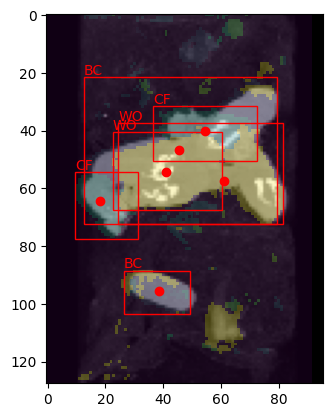

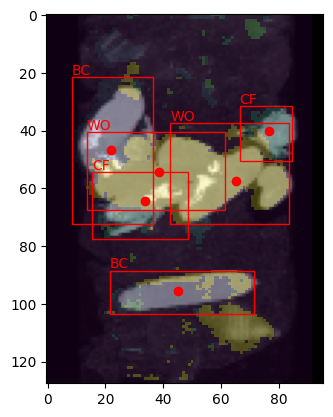

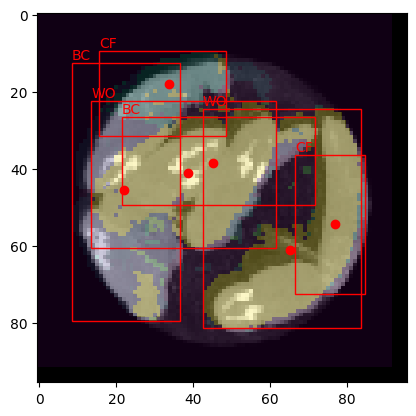

In [21]:
image = img.squeeze().cpu().numpy()
a = 2

#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.25, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')
fig.show()

a = 1
#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.25, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')
fig.show()

a = 0
#fig, ax = plt.subplots(figsize=(10, 10))
fig, ax = plt.subplots()
ax.imshow(image.max(axis=a), cmap='gray')
ax.imshow(pred['pred'][0].argmax(axis=0).max(axis=a), alpha=0.25, interpolation='none')
for box, center, label in zip(pred['boxes'], pred['centers'], pred['labels']):
    if a == 0:
        center = (center[2] - 0.5, center[1] - 0.5)
        xy = (box[2] - 0.5, box[1] - 0.5)
        height = box[4] - box[1]
        width = box[5] - box[2]
    elif a == 1:
        center = (center[2] - 0.5, center[0] - 0.5)
        xy = (box[2] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[5] - box[2]
    else:
        center = (center[1] - 0.5, center[0] - 0.5)
        xy = (box[1] - 0.5, box[0] - 0.5)
        height = box[3] - box[0]
        width = box[4] - box[1]
    ax.add_patch(
        Rectangle(xy, width, height, edgecolor='r', facecolor='none'))
    ax.plot(center[0], center[1], 'ro')
    ax.text(xy[0], xy[1] - 1, class_names[label - 1], color='r')
fig.show()

In [22]:
center_dict_p = {"label":[],"x":[],"y":[],"z":[]}
for i in pred["labels"]:
    center_dict_p["label"].append(to_abbreviation_dict[i])
for i in pred["centers"]:
    center_dict_p["z"].append(i[0])
    center_dict_p["y"].append(i[1])
    center_dict_p["x"].append(i[2])
pd.DataFrame(center_dict_p)

,label,x,y,z
0,BC,22.527497,45.971436,47.139170
1,BC,45.541817,39.018367,96.136438
2,CF,77.337628,54.946812,40.524612
3,CF,34.084896,18.554298,64.948709
4,WO,65.671458,61.759280,57.947714
5,WO,39.253548,41.540809,54.709622


In [18]:
center_dict = {"label":[],"x":[],"y":[],"z":[]}

for i in range(int(len(centerpoints[0].split(";"))/4)):
    temp = centerpoints[0].split(";")
    center_dict["label"].append(temp[4*i])
    center_dict["x"].append(temp[4*i+1])
    center_dict["y"].append(temp[4*i+2])
    center_dict["z"].append(temp[4*i+3])

pd.DataFrame(center_dict)

,label,x,y,z
0,bl,48.61,39.14,96.19
1,bl,77.71,53.14,57.17
2,pp,58.71,73.71,59.15
3,pp,48.42,45.33,51.75
4,pp,19.84,62.44,40.23
5,pp,22.67,30.00,53.13
6,pp,29.98,42.06,60.16
7,bc,78.57,57.98,41.85
8,bc,30.56,19.43,65.24
9,bc,29.44,59.37,47.22


In [6]:
def pack_prediction(centers, labels):
    centers = centers - np.array([[0, 18, 18]])
    strings = []
    for l, c in zip(labels, centers):
        strings.append(f"{l};{c[2]};{c[1]};{c[0]}")
    return ";".join(strings)

In [13]:
submission = {
    'filename': [],
    'centerpoints': [],
}
for img, centerpoint,image_path in tqdm(test_loader):
    img = img.to("cuda")

    pred = predict(img,0.75)
    pred = get_pred(pred)
    pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
    pred_text = pack_prediction(pred['centers'], pred_text_labels)
    submission['filename'].append(image_path[0].split("/")[-1])
    submission['centerpoints'].append(pred_text)
submission = pd.DataFrame(submission)

100%|███████████████████████████████████████████████████████████████████████████████████| 78/78 [01:26<00:00,  1.11s/it]


In [14]:
submission.to_csv(f'validation_.csv', index=False)

In [33]:
def make_submission(threshold):
    submission = {
        'filename': [],
        'centerpoints': [],
    }
    for img, centerpoint,image_path in tqdm(test_loader):
        img = img.to("cuda")
    
        pred = predict(img,threshold)
        pred = get_pred(pred)
        pred_text_labels = [class_names[l - 1].lower() for l in pred['labels']]
        pred_text = pack_prediction(pred['centers'], pred_text_labels)
        submission['filename'].append(image_path[0].split("/")[-1])
        submission['centerpoints'].append(pred_text)
    submission = pd.DataFrame(submission)
    submission.to_csv(f'submission_{threshold}.csv', index=False)

In [7]:
make_submission(0.75)

100%|█████████████████████████████████████████████████████████████████████████████████| 310/310 [07:12<00:00,  1.40s/it]


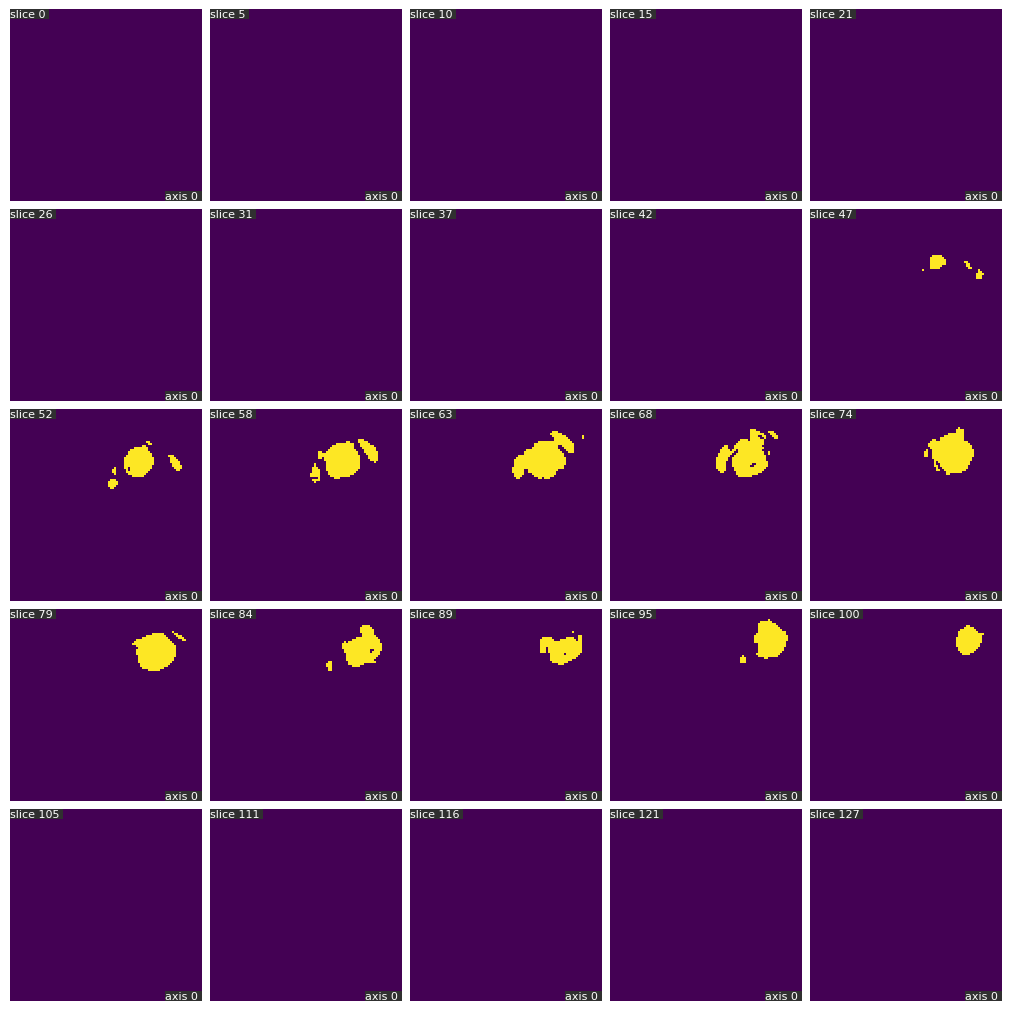

In [357]:
qim3d.viz.slices(m == uniques[1],n_slices=25)